# Random Forest model

#### In this notebook, a Random Forest model will be developed. The text data will be converted into a structured numeric dataframe using TF-IDF Vectorizer.

Importing libraries:

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, plot_roc_curve, roc_auc_score

Loading and merging data:

In [8]:
crypto = pd.read_csv('../data/sub-crypto.csv')
eco = pd.read_csv('../data/sub-economics.csv')

data = crypto.append(eco)
data.head()

,subreddit,title
0,CryptoMarkets,Polychain and Celo Validator Community Bootstr...
1,CryptoMarkets,What's the Economics Of Public Goods ? :O
2,CryptoMarkets,Invesco pulls Bitcoin ETF application and othe...
3,CryptoMarkets,New York State Watchdog Orders Two Crypto Firm...
4,CryptoMarkets,New milestone: ProShares Bitcoin ETF goes publ...


In [9]:
data.shape

(20000, 2)

One hot encoding 'subreddit' column:

In [10]:
#one-hot encoding 'subreddit' column
data['subreddit'].replace({'CryptoMarkets': 0, 'Economics': 1}, inplace = True)
data.head()

,subreddit,title
0,0,Polychain and Celo Validator Community Bootstr...
1,0,What's the Economics Of Public Goods ? :O
2,0,Invesco pulls Bitcoin ETF application and othe...
3,0,New York State Watchdog Orders Two Crypto Firm...
4,0,New milestone: ProShares Bitcoin ETF goes publ...


Shuffling data:

In [11]:
# code from: https://stackoverflow.com/questions/29576430/shuffle-dataframe-rows
data = data.sample(frac = 1)

data.head()

,subreddit,title
6533,0,🐒🔥goldenmonkeycoin.com🍌🙊 $GMONKEY🐵Presale comi...
2127,0,State of the MOONion: r/CryptoCurrency Subredd...
9242,1,Impacts of household income on beef at-home co...
5941,1,Taliban won't be allowed access to Afghan cent...
2973,1,Fathers Dream To Raise Kids And Work From Home...


## Modeling using  CountVecotizer:

In [12]:
# Defining matrixes
X = data['title']
y = data['subreddit']

# Train/Test splitting
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42, stratify=y)

# Vectorize and plot but using 'english' stopwords, unigrams and bigrams
cvec = CountVectorizer(stop_words='english', ngram_range=(1,2))

X_train = cvec.fit_transform(X_train)
X_val = cvec.transform(X_val)

Instantiating RandomForestClassifier and Gridsearch:

In [13]:
# Instantiate RF.
kf = KFold(5, shuffle=True, random_state=42)

rf_params = {
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 1, 2, 3, 4, 5],
}

model_1 = RandomForestClassifier()

gs = GridSearchCV(model_1, rf_params, cv=kf, n_jobs=-1, verbose=1)

# # Fit on training data.
gs.fit(X_train, y_train);

Fitting 5 folds for each of 18 candidates, totalling 90 fits


Measuring performance:

In [15]:
gs.best_score_

0.8808

In [16]:
gs.score(X_train, y_train)

0.9969333333333333

In [17]:
gs.score(X_val, y_val)

0.895

Confusion Matrix:

In [18]:
# Get predictions
preds_cvec = gs.predict(X_val)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_val, preds_cvec).ravel()

# Calculate the specificity and precision

spec = tn / (tn + fp)
prec = tp / (tp + fp)

print('Specificity:', spec)
print('Precision:', prec)

Specificity: 0.954
Precision: 0.9478458049886621


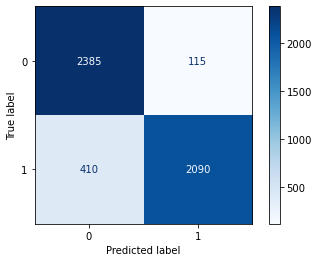

In [19]:
# visualize this
plot_confusion_matrix(gs, X_val, y_val, cmap='Blues', values_format='d');

## Receiver Operating Characteristic (ROC) Curve

This curve helps us visualize our tradeoff between _sensitivity_ and _specificity_ and understand how well-separated our populations are.

### Interpreting ROC AUC
- If you have an ROC AUC of 0.5, your positive and negative populations perfectly overlap and your model is as bad as it can get.
- If you have an ROC AUC of 1, your positive and negative populations are perfectly separated and your model is as good as it can get.
- The closer your ROC AUC is to 1, the better. (1 is the maximum score.)
- If you have an ROC AUC of below 0.5, your positive and negative distributions have flipped sides.

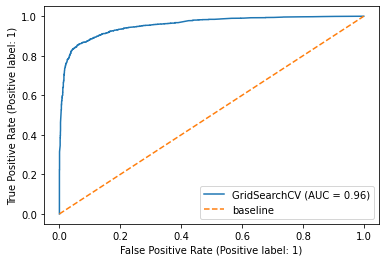

In [20]:
# ROC curve
plot_roc_curve(gs, X_val, y_val)

# add worst case scenario line
plt.plot([0, 1], [0, 1], label="baseline", linestyle="--")

# add a legend
plt.legend();

In [21]:
# Calculate ROC AUC.
roc_auc_score(y_val, gs.predict_proba(X_val)[:,1])

0.9563697600000001

## Modeling using TF-IDF Vecotizer:

In [6]:
# Defining matrixes
X = data['title']
y = data['subreddit']

# Train/Test splitting
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42, stratify=y)

# Vectorize and plot but using 'english' stopwords, unigrams and bigrams
tvec = TfidfVectorizer(stop_words='english', ngram_range=(1,2))

X_train = tvec.fit_transform(X_train)
X_val = tvec.transform(X_val)

Instantiating RandomForestClassifier and Gridsearch:

In [7]:
# Instantiate RF.
kf = KFold(5, shuffle=True, random_state=42)

rf_params = {
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 1, 2, 3, 4, 5],
}

model = RandomForestClassifier()

gs = GridSearchCV(model, rf_params, cv=kf, n_jobs=-1, verbose=1)

# # Fit on training data.
gs.fit(X_train, y_train);

Fitting 5 folds for each of 18 candidates, totalling 90 fits


Measuring performance:

In [8]:
gs.best_score_

0.8835333333333333

In [9]:
gs.score(X_train, y_train)

0.9966666666666667

In [10]:
gs.score(X_val, y_val)

0.8888

Confusion Matrix:

In [11]:
# Get predictions
preds_tvec = gs.predict(X_val)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_val, preds_tvec).ravel()

# Calculate the specificity and precision

spec = tn / (tn + fp)
prec = tp / (tp + fp)

print('Specificity:', spec)
print('Precision:', prec)

Specificity: 0.9492
Precision: 0.9422202001819836


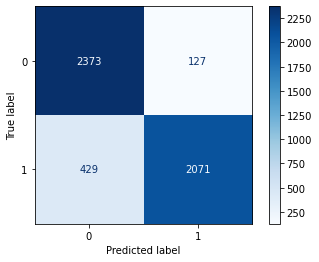

In [12]:
# visualize this
plot_confusion_matrix(gs, X_val, y_val, cmap='Blues', values_format='d');

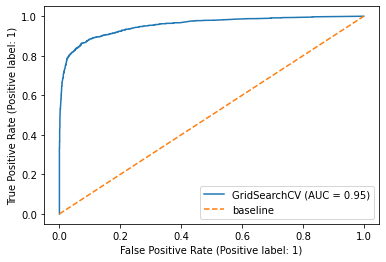

In [13]:
# ROC curve
plot_roc_curve(gs, X_val, y_val)

# add worst case scenario line
plt.plot([0, 1], [0, 1], label="baseline", linestyle="--")

# add a legend
plt.legend();

In [14]:
# Calculate ROC AUC.
roc_auc_score(y_val, gs.predict_proba(X_val)[:,1])

0.95425872